In [1]:
from typing import List, Callable, Union, Dict, Any
import random
import operator
import functools
from functools import reduce

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import jax
import jax.numpy as jnp
from ott.geometry import costs, pointcloud
from ott.tools import sinkhorn_divergence, progot
from ott.problems.linear import linear_problem

c:\Users\courn\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

"""
Package for computing an optimal rank-annealing schedule for Hierarchical Refinement
"""

def rank_annealing__optimal_rank_schedule(n, hierarchy_depth=6, max_Q=int(2**10), max_rank=16):
    """
    
    A function to compute the optimal rank-scheduler of refinement.
    
    Parameters
    ----------
    n: int
        Size of the input dataset -- cannot be a prime number
    hierarchy_depth: int
        Maximal permissible depth of the multi-scale hierarchy
    max_Q: int
        Maximal rank at terminal base case (before reducing the \leq max_Q rank coupling to a 1-1 alignment)
    max_rank: int
        Maximal rank at the intermediate steps of the rank-schedule
        
    """

    # Factoring out the max factor
    Q = rank_annealing__max_factor_lX(n, max_Q)
    ndivQ = int(n / Q)

    # Compute partial rank schedule up to Q
    min_value, rank_schedule = rank_annealing__min_sum_partial_products_with_factors(ndivQ, hierarchy_depth, max_rank)
    rank_schedule.sort()
    rank_schedule.append(Q)
    rank_schedule = [x for x in rank_schedule if x != 1]
    
    print(f'Optimized rank-annealing schedule: { rank_schedule }')
    
    assert functools.reduce(operator.mul, rank_schedule) == n, "Error! Rank-schedule does not factorize n!"
    
    return rank_schedule

def rank_annealing__factors(n):
    # Return list of all factors of an integer
    return set(reduce(
        list.__add__,
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

def rank_annealing__max_factor_lX(n, max_X):
    # Find max factor of n , such that max_factor \leq max_X
    factor_lst = rank_annealing__factors(n)
    max_factor = 0
    for factor in factor_lst:
        if factor > max_factor and factor < max_X:
            max_factor = factor
    return max_factor

def rank_annealing__min_sum_partial_products_with_factors(n, k, C):
    """
    Dynamic program to compute the rank-schedule, subject to a constraint of intermediates being \leq C

    Parameters
    ----------
    n: int
        The dataset size to be factored into a rank-scheduler. Assumed to be non-prime.
    k: int
        The depth of the hierarchy.
    C: int
        A constraint on the maximal intermediate rank across the hierarchy.
    
    """
    INF = float('inf')
    
    dp = [[INF]*(k+1) for _ in range(n+1)]
    choice = [[-1]*(k+1) for _ in range(n+1)]
    
    for d in range(1, n+1):
        if d <= C:
            dp[d][1] = d
            choice[d][1] = d
    
    for t in range(2, k+1):
        for d in range(1, n+1):
            if dp[d][t-1] == INF and t > 1:
                pass
            
            for r in range(1, min(C,d)+1):
                if d % r == 0:
                    candidate = r + r * dp[d // r][t-1]
                    if candidate < dp[d][t]:
                        dp[d][t] = candidate
                        choice[d][t] = r
    
    
    if dp[n][k] == INF:
        return None, []
    
    factors = []
    d_cur, t_cur = n, k
    
    while t_cur > 0:
        r_cur = choice[d_cur][t_cur]
        factors.append(r_cur)
        d_cur //= r_cur
        t_cur -= 1
    
    return dp[n][k], factors



In [21]:
def utils__initialize_couplings(a, b, gQ, gR, gamma, \
                         full_rank=True, device='cpu', \
                         dtype=torch.float64, rank2_random=False, \
                        max_iter=50):
    '''
    ------Parameters------
    a: torch tensor
        Left outer marginal, should be positive and sum to 1.0
    b: torch tensor
        Right outer marginal, should be positive and sum to 1.0
    gQ: torch tensor
        Left inner marginal, should be positive and sum to 1.0
    gR: torch tensor
        Right inner marginal, should be positive and sum to 1.0
    gamma: float
        Step-size of the coordinate MD
    full_rank: bool
        If True, initialize a full-rank set of sub-couplings.
        Else if False, initialize with a rank-2 initialization.
    device: str
        'cpu' if running on CPU, else 'cuda' for GPU
    dtype: torch dtype
        Defaults to float64
    rank2_random: bool
        If False, use deterministic rank 2 initialization of Scetbon '21
        Else, use an initialization with randomly sampled vector on simplex.
    max_iter: int
        The maximum number of Sinkhorn iterations for initialized sub-couplings.
    '''
    N1, N2 = a.size(dim=0), b.size(dim=0)
    r, r2 = gQ.size(dim=0), gR.size(dim=0)
    one_N1 = torch.ones((N1), device=device, dtype=dtype)
    one_N2 = torch.ones((N2), device=device, dtype=dtype)
    
    if full_rank:
        '''
        A means of initializing full-rank sub-coupling matrices using randomly sampled matrices
        and Sinkhorn projection onto the polytope of feasible couplings.

        Only non-diagonal initialization for the LC-factorization and handles the case of unequal
        inner left and right ranks (non-square latent couplings).
        '''
        # 1. Q-generation
        # Generate a random (full-rank) matrix as our coupling initialization
        C_random = torch.rand((N1,r), device=device, dtype=dtype)
        '''
        # Generate a random Kernel
        xi_random = torch.exp( -C_random )
        # Generate a random coupling
        u, v = Sinkhorn(xi_random, a, gQ, N1, r, gamma, device=device, max_iter=max_iter, dtype=dtype)
        Q = torch.diag(u) @ xi_random @ torch.diag(v)
        '''
        Q = utils__logSinkhorn(C_random, a, gQ, gamma, max_iter = max_iter, \
                         device=device, dtype=dtype, balanced=True, unbalanced=False)
        
        # 2. R-generation
        C_random = torch.rand((N2,r2), device=device, dtype=dtype)
        '''
        xi_random = torch.exp( -C_random )
        u, v = Sinkhorn(xi_random, b, gR, N2, r2, gamma, device=device, max_iter=max_iter, dtype=dtype)
        R = torch.diag(u) @ xi_random @ torch.diag(v)'''
        R = utils__logSinkhorn(C_random, b, gR, gamma, max_iter = max_iter, \
                         device=device, dtype=dtype, balanced=True, unbalanced=False)
        
        # 3. T-generation
        gR, gQ = R.T @ one_N2, Q.T @ one_N1
        C_random = torch.rand((r,r2), device=device, dtype=dtype)
        '''
        xi_random = torch.exp( -C_random )
        u, v = Sinkhorn(xi_random, gQ, gR, r, r2, gamma, device=device, max_iter=max_iter, dtype=dtype)
        T = torch.diag(u) @ xi_random @ torch.diag(v)
        '''
        T = utils__logSinkhorn(C_random, gQ, gR, gamma, max_iter = max_iter, \
                         device=device, dtype=dtype, balanced=True, unbalanced=False)
        
        # Use this to form the inner inverse coupling
        if r == r2:
            Lambda = torch.linalg.inv(T)
        else:
            Lambda = torch.diag(1/gQ) @ T @ torch.diag(1/gR)
            #also, could do: torch.diag(1/gQ) @ T @ torch.diag(1/gR)
    elif r == r2:
        '''
        Rank-2 initialization which requires equal inner ranks and gQ = gR = g.
        This is adapted from "Low-Rank Sinkhorn Factorization" at https://arxiv.org/pdf/2103.04737
        We advise setting full_rank = True and using the first initialization.
        '''
        g = gQ
        lambd = torch.min(torch.tensor([torch.min(a), torch.min(b), torch.min(g)])) / 2

        if rank2_random:
            # Take random sample from probability simplex
            a1 = utils__random_simplex_sample(N1, device=device, dtype=dtype)
            b1 = utils__random_simplex_sample(N2, device=device, dtype=dtype)
            g1 = utils__random_simplex_sample(r, device=device, dtype=dtype)
        else:
            # or initialize exactly as in scetbon 21' ott-jax repo
            g1 = torch.arange(1, r + 1, device=device, dtype=dtype)
            g1 /= g1.sum()
            a1 = torch.arange(1, N1 + 1, device=device, dtype=dtype)
            a1 /= a1.sum()
            b1 = torch.arange(1, N2 + 1, device=device, dtype=dtype)
            b1 /= b1.sum()
        
        a2 = (a - lambd*a1)/(1 - lambd)
        b2 = (b - lambd*b1)/(1 - lambd)
        g2 = (g - lambd*g1)/(1 - lambd)
        
        # Generate Rank-2 Couplings
        Q = lambd*torch.outer(a1, g1).to(device) + (1 - lambd)*torch.outer(a2, g2).to(device)
        R = lambd*torch.outer(b1, g1).to(device) + (1 - lambd)*torch.outer(b2, g2).to(device)
        
        # This is already determined as g (but recomputed anyway)
        gR, gQ = R.T @ one_N2, Q.T @ one_N1
        
        # Last term adds very tiny off-diagonal component for the non-diagonal LC-factorization (o/w the matrix stays fully diagonal)
        T = (1-lambd)*torch.diag(g) + lambd*torch.outer(gR, gQ).to(device)
        Lambda = torch.linalg.inv(T)
    
    return Q, R, T, Lambda


def utils__k_means_initialization(x0, x1, r1, r2=None, \
                           a=None, b=None, gQ=None, gR=None, \
                           eps = 1e-3, device = 'cpu', \
                           dtype=torch.float64):
    '''
    An initialization relying on a pair of k-means clusterings on the first and second dataset.
    ------Parameters------
    x0: torch.tensor
        First N1 x d dataset for d the data-dimension
    x1: torch.tensor
        Second N2 x d dataset for d the data-dimension
    r1: int
        Latent source rank
    r2: int
        Latent target rank
    a: torch tensor
        Left outer marginal, should be positive and sum to 1.0
    b: torch tensor
        Right outer marginal, should be positive and sum to 1.0
    gQ: torch tensor
        Left inner marginal, should be positive and sum to 1.0
    gR: torch tensor
        Right inner marginal, should be positive and sum to 1.0
    eps: float
        Epsilon used for Sinkhorn to generate the sub-couplings.
    device: str
        'cpu' if running on CPU, else 'cuda' for GPU
    dtype: torch dtype
        Defaults to float64
    '''
    n, m =  x0.size(dim=0), x1.size(dim=0)
    # Initialize outer marginals
    if a is None:
        one_n = torch.ones((n), device=device, dtype=dtype)
        a = one_n / n
    if b is None:
        one_m = torch.ones((m), device=device, dtype=dtype)
        b = one_m / m
    # Set ranks equal if second rank not given  
    if r2 is None:
        r2 = r1
    
    if gQ is None:
        one_r1 = torch.ones((r1), device=device, dtype=dtype)
        gQ = one_r1 / r1
    if gR is None:
        one_r2 = torch.ones((r2), device=device, dtype=dtype)
        gR = one_r2 / r2
    _x0, _x1 = x0.cpu().numpy(), x1.cpu().numpy()
    # Compute optimal clustering to initialize OT alignment
    y0 = KMeans(n_clusters=r1, n_init="auto").fit(_x0).cluster_centers_
    y1 = KMeans(n_clusters=r2, n_init="auto").fit(_x1).cluster_centers_
    # Move back to tensor
    x0,x1=x0.double(),x1.double()
    y0,y1 = torch.from_numpy(y0).to(device).double(),torch.from_numpy(y1).to(device).double()
    # Compute distance matrices
    CQ,CT,CR = torch.cdist(x0, y0), torch.cdist(y0, y1), torch.cdist(x1,y1)
    # Generate Kernel
    xiQ, xiR, xiT = torch.exp( -CQ / eps ), torch.exp( -CR / eps ), torch.exp( -CT / eps )
    
    # Generate couplings
    u, v = utils__Sinkhorn(xiQ, a, gQ, n, r1, eps, device=device)
    Q = torch.diag(u) @ xiQ @ torch.diag(v)
    u, v = utils__Sinkhorn(xiR, b, gR, m, r2, eps, device=device)
    R = torch.diag(u) @ xiR @ torch.diag(v)
    u, v = utils__Sinkhorn(xiT, gQ, gR, r1, r2, eps, device=device)
    T = torch.diag(u) @ xiT @ torch.diag(v)
    
    return (Q,R,T)




def utils__random_simplex_sample(N, device='cpu', dtype=torch.float64):
    # Samples a random N-dimensional vector from the simplex
    d = torch.exp(torch.randn(N, device=device, dtype=dtype))
    return d / torch.sum(d)




def utils__semi_project_Left(xi1, a, g, N1, r, gamma_k, tau, max_iter = 50, \
                      delta = 1e-9, device='cpu', dtype=torch.float64):
    '''
    Semi-relaxed Sinkhorn with tight left marginal.
    '''
    u = torch.ones((N1), device=device, dtype=dtype)
    v = torch.ones((r), device=device, dtype=dtype)
    u_tild = u
    v_tild = v
    i = 0
    while i == 0 or (i < max_iter and 
                     gamma_k**-1 * torch.max(torch.tensor([torch.max(torch.log(u/u_tild)),torch.max(torch.log(v/v_tild))])) > delta ):
        u_tild = u
        v_tild = v
        u = (a / (xi1 @ v))**(tau/(tau + gamma_k**-1 ))
        v = (g / (xi1.T @ u))
        i+=1
    
    return u, v




def utils__semi_project_Right(xi2, b, g, N2, r, gamma_k, tau, max_iter = 50, \
                       delta = 1e-9, device='cpu', dtype=torch.float64):
    '''
    Semi-relaxed Sinkhorn with tight right marginal.
    '''
    u = torch.ones((N2), device=device, dtype=dtype)
    v = torch.ones((r), device=device, dtype=dtype)
    u_tild = u
    v_tild = v
    i = 0
    while i == 0 or (i < max_iter and 
                     gamma_k**-1 * torch.max(torch.tensor([torch.max(torch.log(u/u_tild)),torch.max(torch.log(v/v_tild))])) > delta ):
        u_tild = u
        v_tild = v
        u = (b / (xi2 @ v))**(tau/(tau + gamma_k**-1 ))
        v = (g / (xi2.T @ u))
        i+=1
    
    return u, v




def utils__semi_project_Balanced(xi1, a, g, N1, r, gamma_k, tau, max_iter = 50, \
                          delta = 1e-9, device='cpu', dtype=torch.float64):
    # Lax-inner marginal
    u = torch.ones((N1), device=device, dtype=dtype)
    v = torch.ones((r), device=device, dtype=dtype)
    u_tild = u
    v_tild = v
    i = 0
    while i == 0 or (i < max_iter and 
                     gamma_k**-1 * torch.max(torch.tensor([torch.max(torch.log(u/u_tild)),torch.max(torch.log(v/v_tild))])) > delta ):
        u_tild = u
        v_tild = v
        v = (g / (xi1.T @ u))**(tau/(tau + gamma_k**-1 ))
        u = (a / (xi1 @ v))
        i+=1
    
    return u, v


def utils__project_Unbalanced(xi1, a, g, N1, r, gamma_k, tau, max_iter = 50, \
                       delta = 1e-9, device='cpu', dtype=torch.float64):
    '''
    Fully-relaxed Sinkhorn with relaxed left and right marginals.
    '''
    # Unbalanced
    u = torch.ones((N1), device=device, dtype=dtype)
    v = torch.ones((r), device=device, dtype=dtype)
    u_tild = u
    v_tild = v
    i = 0
    while i == 0 or (i < max_iter and 
                     gamma_k**-1 * torch.max(torch.tensor([torch.max(torch.log(u/u_tild)),torch.max(torch.log(v/v_tild))])) > delta ):
        u_tild = u
        v_tild = v
        v = (g / (xi1.T @ u))**(tau/(tau + gamma_k**-1 ))
        u = (a / (xi1 @ v))**(tau/(tau + gamma_k**-1 ))
        i+=1
    
    return u, v

def utils__logSinkhorn(grad, a, b, gamma_k, max_iter = 50, \
             device='cpu', dtype=torch.float64, balanced=True, unbalanced=False, tau=None, tau2=None):
    
    log_a = torch.log(a)
    log_b = torch.log(b)

    n, m = a.size(0), b.size(0)
    
    f_k = torch.zeros((n), device=device)
    g_k = torch.zeros((m), device=device)

    epsilon = gamma_k**-1
    
    if not balanced:
        ubc = (tau/(tau + epsilon ))
        if tau2 is not None:
            ubc2 = (tau2/(tau2 + epsilon ))
    
    for i in range(max_iter):
        if balanced and not unbalanced:
            # Balanced
            f_k = f_k + epsilon*(log_a - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=1))
            g_k = g_k + epsilon*(log_b - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=0))
        elif not balanced and unbalanced:
            # Unbalanced
            f_k = ubc*(f_k + epsilon*(log_a - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=1)) )
            g_k = ubc2*(g_k + epsilon*(log_b - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=0)) )
        else:
            # Semi-relaxed
            f_k = (f_k + epsilon*(log_a - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=1)) )
            g_k = ubc*(g_k + epsilon*(log_b - torch.logsumexp(utils__Cost(f_k, g_k, grad, epsilon, device=device), axis=0)) )

    P = torch.exp(utils__Cost(f_k, g_k, grad, epsilon, device=device))
    
    return P

def utils__Sinkhorn(xi, a, b, N1, r, gamma_k, max_iter = 50, \
             delta = 1e-9, device='cpu', dtype=torch.float64):
    '''
    A lightweight impl of Sinkhorn.
    ------Parameters------
    xi: torch tensor
        An n x m matrix of the exponentiated positive Sinkhorn kernel.
    a: torch tensor
        Left outer marginal, should be positive and sum to 1.0
    b: torch tensor
        Right outer marginal, should be positive and sum to 1.0
    N1: int
        Dimension 1
    r: int
        Dimension 2
    gamma_k: float
        Step-size used for scaling convergence criterion.
    max_iter: int
        Maximum number of iterations for Sinkhorn loop
    delta: float
        Used for determining convergence to marginals
    device: str
        'cpu' if running on CPU, else 'cuda' for GPU
    dtype: torch dtype
        Defaults to float64
    '''
    u = torch.ones((N1), device=device, dtype=dtype)
    v = torch.ones((r), device=device, dtype=dtype)
    u_tild = u
    v_tild = v
    i = 0
    
    while i == 0 or (i < max_iter and 
                     gamma_k**-1 * torch.max(torch.tensor([torch.max(torch.log(u/u_tild)),torch.max(torch.log(v/v_tild))])) > delta ):
        
        u_tild = u
        v_tild = v
        u = (a / (xi @ v))
        v = (b / (xi.T @ u))
        i+=1
        
    return u, v

def utils__Cost(f, g, Grad, epsilon, device='cpu', dtype=torch.float64):
    '''
    A matrix which is using for the broadcasted log-domain log-sum-exp trick-based updates.
    ------Parameters------
    f: torch.tensor (N1)
        First dual variable of semi-unbalanced Sinkhorn
    g: torch.tensor (N2)
        Second dual variable of semi-unbalanced Sinkhorn
    Grad: torch.tensor (N1 x N2)
        A collection of terms in our gradient for the update
    epsilon: float
        Entropic regularization for Sinkhorn
    device: 'str'
        Device tensors placed on
    '''
    return -( Grad - torch.outer(f, torch.ones(Grad.size(dim=1), device=device)) - torch.outer(torch.ones(Grad.size(dim=0), device=device), g) ) / epsilon



def utils__Delta(vark, varkm1, gamma_k):
    '''
    Convergence criterion for FRLC.
    ------Parameters------
    vark: tuple of 3-tensors
        Tuple of coordinate MD block variables (Q,R,T) at current iter
    varkm1:  tuple of 3-tensors
        Tuple of coordinate MD block variables (Q,R,T) at previous iter
    gamma_k: float
        Coordinate MD step-size
    '''
    Q, R, T = vark
    Q_prev, R_prev, T_prev = varkm1
    error = (gamma_k**-2)*(torch.norm(Q - Q_prev) + torch.norm(R - R_prev) + torch.norm(T - T_prev))
    return error


def utils__low_rank_distance_factorization(X1, X2, r, eps, device='cpu', dtype=torch.float64):
    n = X1.shape[0]
    m = X2.shape[0]
    '''
    Indyk '19
    '''
    # low-rank distance matrix factorization of Bauscke, Indyk, Woodruff
    
    t = int(r/eps) # this is poly(1/eps, r) in general -- this t might not achieve the correct bound tightly
    i_star = random.randint(0, n-1)
    j_star = random.randint(0, m-1)
    
    # Define probabilities of sampling
    p = (torch.cdist(X1, X2[j_star][None,:])**2 \
            + torch.cdist(X1[i_star,:][None,:], X2[j_star,:][None,:])**2 \
                    + (torch.sum(torch.cdist(X1[i_star][None,:], X2))/m) )[:,0]**2
    
    p_dist = (p / p.sum())
    
    # Use random choice to sample rows
    indices_p = torch.from_numpy(np.random.choice(n, size=(t), p=p_dist.cpu().numpy())).to(device)
    indices_p = indices_p.to(torch.long)
    X1_t = X1[indices_p, :]
    '''
    Frieze '04
    '''
    P_t = torch.sqrt(p[indices_p]*t)
    S = torch.cdist(X1_t, X2)/P_t[:, None] # t x m
    
    # Define probabilities of sampling by row norms
    q = torch.norm(S, dim=0)**2 / torch.norm(S)**2 # m x 1
    q_dist = (q / q.sum())
    # Use random choice to sample rows
    indices_q = torch.from_numpy(np.random.choice(m, size=(t), p=q_dist.cpu().numpy())).to(device)
    indices_q = indices_q.to(torch.long)
    S_t = S[:, indices_q] # t x t
    Q_t = torch.sqrt(q[indices_q]*t)
    W = S_t[:, :] / Q_t[None, :]
    # Find U
    U, Sig, Vh = torch.linalg.svd(W) # t x t for all
    F = U[:, :r] # t x r
    # U.T for the final return
    U_t = (S.T @ F) / torch.norm(W.T @ F) # m x r
    '''
    Chen & Price '17
    '''
    # Find V for the final return
    indices = torch.from_numpy(np.random.choice(m, size=(t))).to(device)
    indices = indices.to(torch.long)
    X2_t = X2[indices, :] # t x dim
    D_t = torch.cdist(X1, X2_t) / np.sqrt(t) # n x t
    Q = U_t.T @ U_t # r x r
    U, Sig, Vh = torch.linalg.svd(Q)
    U = U / Sig # r x r
    U_tSub = U_t[indices, :].T # t x r
    B = U.T @ U_tSub / np.sqrt(t) # (r x r) (r x t)
    A = torch.linalg.inv(B @ B.T)
    Z = ((A @ B) @ D_t.T) # (r x r) (r x t) (t x n)
    V = Z.T @ U
    return V.double(), U_t.T.double()

def utils__hadamard_square_lr(A1, A2, device='cpu'):
    """
    Input
        A1: torch.tensor, low-rank subcoupling of shape (n, r)
        A2: torch.tensor, low-rank subcoupling of shape (n, r)
                ( such that A \approx A1 @ A2.T )
    
    Output
        A1_tilde: torch.tensor, low-rank subcoupling of shape (n, r**2)
        A2_tilde: torch.tensor, low-rank subcoupling of shape (n, r**2)
               ( such that A * A \approx A1_tilde @ A2_tilde.T )
    """
    
    A1 = A1.to(device)
    A2 = A2.to(device)
    n, r = A1.shape
    A1_tilde = torch.einsum("ij,ik->ijk", A1, A1).reshape(n, r * r)
    A2_tilde = torch.einsum("ij,ik->ijk", A2, A2).reshape(n, r * r)
    
    return A1_tilde, A2_tilde


def utils__hadamard_lr(A1, A2, B1, B2, device='cpu'):
    """
    Input
        A1: torch.tensor, low-rank subcoupling of shape (n, r)
        A2: torch.tensor, low-rank subcoupling of shape (n, r)
                ( such that A \approx A1 @ A2.T )
        
        B1: torch.tensor, low-rank subcoupling of shape (n, r)
        B2: torch.tensor, low-rank subcoupling of shape (n, r)
                ( such that B \approx B1 @ B2.T )
    
    Output
        M1_tilde: torch.tensor, low-rank subcoupling of shape (n, r**2)
        M2_tilde: torch.tensor, low-rank subcoupling of shape (n, r**2)
               ( such that A * B \approx M1_tilde @ M2_tilde.T given low-rank factorizations for A & B)
    """
    A1 = A1.to(device)
    A2 = A2.to(device)
    B1 = B1.to(device)
    B2 = B2.to(device)
    n, r = A1.shape

    M1_tilde = torch.einsum("ij,ik->ijk", A1, B1).reshape(n, r * r)
    M2_tilde = torch.einsum("ij,ik->ijk", A2, B2).reshape(n, r * r)
    
    return M1_tilde, M2_tilde

def utils__LC_proj(X0, X1, Q, R):
    
    gQ = torch.sum(Q,axis=0)
    Q_barycenters = torch.diag(1/gQ) @ Q.T @ X0
    gR = torch.sum(R,axis=0)
    R_barycenters = torch.diag(1/gR) @ R.T @ X1

    return Q_barycenters, R_barycenters

In [4]:
def gd__compute_grad_A(C, Q, R, Lambda, gamma, \
                   semiRelaxedLeft, semiRelaxedRight, device, \
                   Wasserstein=True, FGW=False, A=None, B=None, \
                   alpha=0.0, unbalanced=False, \
                   dtype=torch.float64, full_grad=True):
    
    '''
    Code for computing the Wasserstein, Gromov-Wasserstein, and fused Gromov-Wasserstein gradients with respect to Q and R.
    These depend on the marginal relaxation of the specific OT problem you want to solve, due to proportionality simplifications.
    
    ------Parameters------
    C: torch.tensor (N1 x N2)
        A matrix of pairwise feature distances in space X and space Y (inter-space).
    Q: torch.tensor (N1 x r)
        The left sub-coupling matrix.
    R: torch.tensor (N2 x r)
        The right sub-coupling matrix.
    Lambda: torch.tensor (r x r)
        The inner transition matrix.
    gamma: float
        The mirror-descent step-size.
    semiRelaxedLeft: bool
        True if relaxing the left marginal.
    semiRelaxedRight: bool
        True if relaxing the right marginal.
    device: str
        The device (i.e. 'cpu' or 'cuda')
    Wasserstein: bool
        True if using the Wasserstein loss <C, P>_F as the objective cost,
        else runs GW if FGW false and FGW if GW true.
    FGW: bool
        True if running the Fused-Gromov Wasserstein problem, and otherwise false.
    A: torch.tensor (N1 x N1)
        Pairwise distance matrix in metric space X.
    B: torch.tensor (N2 x N2)
        Pairwise distance matrix in metric space Y.
    alpha: float
        A balance parameter between the Wasserstein term and
        the Gromov-Wasserstein term of the objective.
    unbalanced: bool
        True if running the unbalanced problem;
        if semiRelaxedLeft/Right and unbalanced False (default) then running the balanced problem.
    '''
    
    r = Lambda.shape[0]
    one_r = torch.ones((r), device=device, dtype=dtype)
    One_rr = torch.outer(one_r, one_r).to(device)
    
    if Wasserstein:
        gradQ, gradR = gd__Wasserstein_Grad(C, Q, R, Lambda, device, \
                   dtype=dtype, full_grad=full_grad)
        
    elif A is not None and B is not None:
        if not semiRelaxedLeft and not semiRelaxedRight and not unbalanced:
            # Balanced gradient (Q1_r = a AND R1_r = b)
            gradQ = - 4 * (A@Q)@Lambda@(R.T@B@R)@Lambda.T
            gradR = - 4 * (B@R@Lambda.T)@(Q.T@A@Q)@Lambda
        elif semiRelaxedRight:
            # Semi-relaxed right marginal gradient (Q1_r = a)
            gradQ = - 4 * (A@Q)@Lambda@(R.T@B@R)@Lambda.T
            gradR = 2*B**2 @ R @ One_rr - 4*(B@R@Lambda.T)@(Q.T@A@Q)@Lambda
        elif semiRelaxedLeft:
            # Semi-relaxed left marginal gradient (R1_r = b)
            gradQ = 2*A**2 @ Q @ One_rr - 4 * (A@Q)@Lambda@(R.T@B@R)@Lambda.T
            gradR = - 4 * (B@R@Lambda.T)@(Q.T@A@Q)@Lambda
        elif unbalanced:
            # Fully unbalanced with no marginal constraints
            gradQ = 2*A**2 @ Q @ One_rr - 4 * (A@Q)@Lambda@(R.T@B@R)@Lambda.T
            gradR = 2*B**2 @ R @ One_rr - 4 * (B@R@Lambda.T)@(Q.T@A@Q)@Lambda

        if full_grad:
            N1, N2 = Q.shape[0], R.shape[0]
            one_N1, one_N2 = torch.ones((N1), device=device, dtype=dtype), torch.ones((N2), device=device, dtype=dtype)
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            F = (Q@Lambda@R.T)
            MR = Lambda.T @ Q.T @ A @ F @ B @ R @ torch.diag(1/gR)
            MQ = Lambda @ R.T @ B @ F.T @ A @ Q @ torch.diag(1/gQ)
            gradQ += 4*torch.outer(one_N1, torch.diag(MQ))
            gradR += 4*torch.outer(one_N2, torch.diag(MR))
        
        # Readjust cost for FGW problem
        if FGW:
            gradQW, gradRW = gd__Wasserstein_Grad(C, Q, R, Lambda, device, \
                   dtype=dtype, full_grad=full_grad)
            gradQ = (1-alpha)*gradQW + alpha*gradQ
            gradR = (1-alpha)*gradRW + alpha*gradR
    else:
        raise ValueError("---Input either Wasserstein=True or provide distance matrices A and B for GW problem---")
        
    normalizer = torch.max(torch.tensor([torch.max(torch.abs(gradQ)) , torch.max(torch.abs(gradR))]))
    gamma_k = gamma / normalizer
    
    return gradQ, gradR, gamma_k

def gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, gamma, device, Wasserstein=True, \
                   FGW=False, A=None, B=None, alpha=0.0, \
                   dtype=torch.float64):
    '''
    Code for computing the Wasserstein, Gromov-Wasserstein, and fused Gromov-Wasserstein gradients with respect to T.
    
    ------Parameters------
    C: torch.tensor (N1 x N2)
        A matrix of pairwise feature distances in space X and space Y (inter-space).
    Q: torch.tensor (N1 x r)
        The left sub-coupling matrix.
    R: torch.tensor (N2 x r)
        The right sub-coupling matrix.
    Lambda: torch.tensor (r x r)
        The inner transition matrix.
    gQ: torch.tensor (r)
        The inner marginal corresponding to the matrix Q.
    gR: torch.tensor (r)
        The inner marginal corresponding to the matrix R.
    gamma: float
        The mirror-descent step-size.
    device: str
        The device (i.e. 'cpu' or 'cuda')
    Wasserstein: bool
        True if using the Wasserstein loss <C, P>_F as the objective cost,
        else runs GW if FGW false and FGW if GW true.
    FGW: bool
        True if running the Fused-Gromov Wasserstein problem, and otherwise false.
    A: torch.tensor (N1 x N1)
        Pairwise distance matrix in metric space X.
    B: torch.tensor (N2 x N2)
        Pairwise distance matrix in metric space Y.
    alpha: float
        A balance parameter between the Wasserstein term and
        the Gromov-Wasserstein term of the objective.
    '''
    if Wasserstein:
        gradLambda = Q.T @ C @ R
    else:
        gradLambda = -4 * Q.T @ A @ Q @ Lambda @ R.T @ B @ R
        if FGW:
            gradLambda = (1-alpha)*(Q.T @ C @ R) + alpha*gradLambda
    gradT = torch.diag(1/gQ) @ gradLambda @ torch.diag(1/gR) # (mass-reweighted form)
    gamma_T = gamma / torch.max(torch.abs(gradT))
    return gradT, gamma_T

def gd__Wasserstein_Grad(C, Q, R, Lambda, device, \
                   dtype=torch.float64, full_grad=True):
    
    gradQ = (C @ R) @ Lambda.T
    if full_grad:
        # rank-one perturbation
        N1 = Q.shape[0]
        one_N1 = torch.ones((N1), device=device, dtype=dtype)
        gQ = Q.T @ one_N1
        w1 = torch.diag( (gradQ.T @ Q) @ torch.diag(1/gQ) )
        gradQ -= torch.outer(one_N1, w1)
    
    # linear term
    gradR = (C.T @ Q) @ Lambda
    if full_grad:
        # rank-one perturbation
        N2 = R.shape[0]
        one_N2 = torch.ones((N2), device=device, dtype=dtype)
        gR = R.T @ one_N2
        w2 = torch.diag( torch.diag(1/gR) @ (R.T @ gradR) )
        gradR -= torch.outer(one_N2, w2)
    
    return gradQ, gradR

'''
--------------
Code for gradients assuming low-rank distance matrices C, A, B
--------------
'''

def gd__compute_grad_A_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gamma, device, \
                   alpha=0.0, dtype=torch.float64, full_grad=False):
    
    r = Lambda.shape[0]
    one_r = torch.ones((r), device=device, dtype=dtype)
    One_rr = torch.outer(one_r, one_r).to(device)
    N1, N2 = C_factors[0].size(0), C_factors[1].size(1)
    
    if A_factors is not None and B_factors is not None:
        A1, A2 = A_factors[0], A_factors[1]
        B1, B2 = B_factors[0], B_factors[1]
        
        # A*2's low-rank factorization
        A1_tild, A2_tild = utils__hadamard_square_lr(A1, A2.T, device=device)
        
        # GW gradients for balanced marginal cases
        gradQ = - 4 * (A1 @ (A2 @ (Q @ Lambda@( (R.T@ B1) @ (B2 @R) )@Lambda.T)) )
        gradR = - 4 * (B1 @ (B2 @ (R @ (Lambda.T@( (Q.T @ A1) @ ( A2 @ Q ))@Lambda)) ) )
    
        one_N1, one_N2 = torch.ones((N1), device=device, dtype=dtype), torch.ones((N2), device=device, dtype=dtype)
        if full_grad:
            # Rank-1 GW perturbation
            N1, N2 = Q.shape[0], R.shape[0]
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            
            MR = Lambda.T @ ( (Q.T @ A1) @ (A2 @ Q) ) @ Lambda @ ((R.T @ B1) @ (B2 @ R)) @ torch.diag(1/gR)
            MQ = Lambda @ ( (R.T @ B1) @ (B2 @ R) ) @ Lambda.T @ ((Q.T @ A1) @ (A2 @ Q) ) @ torch.diag(1/gQ)
            gradQ += 4*torch.outer(one_N1, torch.diag(MQ))
            gradR += 4*torch.outer(one_N2, torch.diag(MR))
    else:
        gradQ = 0
        gradR = 0
    
    # total gradients -- readjust cost for FGW problem by adding W gradients
    gradQW, gradRW = gd__Wasserstein_Grad_LR(C_factors, Q, R, Lambda, device, \
                                                   dtype=dtype, full_grad=full_grad)
    gradQ = (1-alpha)*gradQW + (alpha/2)*gradQ
    gradR = (1-alpha)*gradRW + (alpha/2)*gradR
    
    normalizer = torch.max(torch.tensor([torch.max(torch.abs(gradQ)) , torch.max(torch.abs(gradR))]))
    gamma_k = gamma / normalizer
    
    return gradQ, gradR, gamma_k

def gd__compute_grad_B_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gQ, gR, gamma, device, \
                   alpha=0.0, dtype=torch.float64):
    
    N1, N2 = C_factors[0].size(0), C_factors[1].size(1)

    if A_factors is not None and B_factors is not None:
        A1, A2 = A_factors[0], A_factors[1]
        B1, B2 = B_factors[0], B_factors[1]
        # GW grad
        gradLambda = -4 * ( (Q.T @ A1) @ (A2 @ Q) ) @ Lambda @ ( (R.T @ B1) @ (B2 @ R) )
        del A1,A2,B1,B2
    else:
        gradLambda = 0
    
    C1, C2 = C_factors[0], C_factors[1]
    # total grad
    gradLambda = (1-alpha)*( (Q.T @ C1) @ (C2 @ R) ) + (alpha/2)*gradLambda
    gradT = torch.diag(1/gQ) @ gradLambda @ torch.diag(1/gR) # (mass-reweighted form)
    gamma_T = gamma / torch.max(torch.abs(gradT))
    return gradT, gamma_T

def gd__Wasserstein_Grad_LR(C_factors, Q, R, Lambda, device, \
                   dtype=torch.float64, full_grad=True):

    C1, C2 = C_factors[0], C_factors[1]
    
    gradQ = C1 @ ((C2 @ R) @ Lambda.T)
    
    if full_grad:
        # rank-one perturbation
        N1 = Q.shape[0]
        one_N1 = torch.ones((N1), device=device, dtype=dtype)
        gQ = Q.T @ one_N1
        w1 = torch.diag( (gradQ.T @ Q) @ torch.diag(1/gQ) )
        gradQ -= torch.outer(one_N1, w1)
    
    # linear term
    gradR = C2.T @ ((C1.T @ Q) @ Lambda)
    if full_grad:
        # rank-one perturbation
        N2 = R.shape[0]
        one_N2 = torch.ones((N2), device=device, dtype=dtype)
        gR = R.T @ one_N2
        w2 = torch.diag( torch.diag(1/gR) @ (R.T @ gradR) )
        gradR -= torch.outer(one_N2, w2)
    
    return gradQ, gradR

In [27]:
def FRLC_opt(C, a=None, b=None, A=None, B=None, tau_in = 50, tau_out=50, \
             gamma=90, r = 10, r2=None, max_iter=200, device='cpu', dtype=torch.float64, \
                  semiRelaxedLeft=False, semiRelaxedRight=False, Wasserstein=True, \
                 printCost=True, returnFull=False, FGW=False, alpha=0.0, unbalanced=False, \
                  initialization='Full', init_args = None, full_grad=True, \
                   convergence_criterion=True, tol=1e-5, min_iter = 25, \
                   min_iterGW = 500, max_iterGW = 1000, \
                   max_inneriters_balanced= 300, max_inneriters_relaxed=50, \
                  diagonalize_return=False):
    
    '''
    FRLC: Factor Relaxation with Latent Coupling
    ------Parameters------
    C: torch.tensor (N1 x N2)
        A matrix of pairwise feature distances in space X and space Y (inter-space).
    a: torch.tensor (N1)
        A vector representing marginal one.
    b: torch.tensor (N2)
        A vector representing marginal two.
    A: torch.tensor (N1 x N1)
        A matrix of pairwise distances between points in metric space X.
    B: torch.tensor (N2 x N2)
        A matrix of pairwise distances between points in metric space Y.
    tau_in: float (> 0)
        A scalar which controls the regularity of the inner marginal update path.
    tau_out: float (> 0)
        A scalar which controls the regularization of the outer marginals a and b (e.g. for semi-relaxed or unbalanced OT)
    gamma: float (> 0)
        The mirror descent step-size, a scalar which controls the scaling of gradients
        before being exponentiated into Sinkhorn kernels.
    r: int (> 1)
        A non-negative integer rank, controlling the rank of the FRLC learned OT coupling. 
    max_iter: int
        The maximal number of iterations FRLC will run until convergence.
    device: str
        The device (i.e. 'cpu' or 'cuda') which FRLC runs on.
    dtype: dtype
        The datatype all tensors are stored on (naturally there is a space-accuracy
        tradeoff for low-rank between 32 and 64 bit).
    semiRelaxedLeft: bool
        True if running the left-marginal relaxed low-rank algorithm.
    semiRelaxedRight: bool
        True if running the right-marginal relaxed low-rank algorithm.
    Wasserstein: bool
        True if using the Wasserstein loss <C, P>_F as the objective cost,
        else runs GW if FGW false and FGW if GW true.
    printCost: bool
        True if printing the value of the objective cost at each iteration.
        This can be expensive for large datasets if C is not factored.
    returnFull: bool
        True if returning P_r = Q Lambda R.T, else returns iterates (Q, R, T).
    FGW: bool
        True if running the Fused-Gromov Wasserstein problem, and otherwise false.
    alpha: float
        A balance parameter between the Wasserstein term and
        the Gromov-Wasserstein term of the objective.
    unbalanced: bool
        True if running the unbalanced problem;
        if semiRelaxedLeft/Right and unbalanced False (default) then running the balanced problem.
    initialization: str, 'Full' or 'Rank-2'
        'Full' if sub-couplings initialized to be full-rank, if 'Rank-2' set to a rank-2 initialization.
        We advise setting this to be 'Full'.
    init_args: tuple of 3-tensors
        A tuple of (Q0, R0, T0) for tuple[i] of type tensor
    full_grad: bool
        If True, evaluates gradient with rank-1 perturbations.
        Else if False, omits perturbation terms.
    convergence_criterion: bool
        If True, use the convergence criterion. Else if False, default to running up to max_iters.
    tol: float
        Tolerance used for established when convergence is reached.
    min_iter: int
        The minimum iterations for the algorithm to run for in the Wasserstein case.
    min_iterGW: int
        The minimum number of iterations to run for in the GW case.
    max_iterGW: int
        The maximum number of iterations to run for in the GW case.
    max_inneriters_balanced: int
        The maximum number of inner iterations for the Sinkhorn loop.
    max_inneriters_relaxed: int
        The maximum number of inner iterations for the relaxed and semi-relaxed loops.
    diagonalize_return: bool
        If True, diagonalize the LC-factorization to the form of Scetbon et al '21.
        Else if False, return the LC-factorization.
    '''

    
    N1, N2 = C.size(dim=0), C.size(dim=1)
    k = 0
    stationarity_gap = torch.inf
    
    one_N1 = torch.ones((N1), device=device, dtype=dtype)
    one_N2 = torch.ones((N2), device=device, dtype=dtype)
    
    if a is None:
        a = one_N1 / N1
    if b is None:
        b = one_N2 / N2
    if r2 is None:
        r2 = r

    one_r = torch.ones((r), device=device, dtype=dtype)
    one_r2 = torch.ones((r2), device=device, dtype=dtype)
    
    # Initialize inner marginals to uniform; 
    # generalized to be of differing dimensions to account for non-square latent-coupling.
    gQ = (1/r)*one_r
    gR = (1/r2)*one_r2
    
    full_rank = True if initialization == 'Full' else False
    
    if initialization == 'Full':
        full_rank = True
    elif initialization == 'Rank-2':
        full_rank = False
    else:
        full_rank = True
        print('Initialization must be either "Full" or "Rank-2", defaulting to "Full".')
        
    if init_args is None:
        Q, R, T, Lambda = utils__initialize_couplings(a, b, gQ, gR, \
                                                    gamma, full_rank=full_rank, \
                                                device=device, dtype=dtype, \
                                                    max_iter = max_inneriters_balanced)
    else:
        Q, R, T = init_args
        Lambda = torch.diag(1/ (Q.T @ one_N1)) @ T @ torch.diag(1/ (R.T @ one_N2))

    if Wasserstein is False:
        min_iter = min_iterGW
        max_iter = max_iterGW

    '''
    Preparing main loop.
    '''
    errs = []
    grad = torch.inf
    gamma_k = gamma
    Q_prev, R_prev, T_prev = None, None, None
    
    while (k < max_iter and (not convergence_criterion or \
                       (k < min_iter or utils__Delta((Q, R, T), (Q_prev, R_prev, T_prev), gamma_k) > tol))):
        
        if convergence_criterion:
            # Set previous iterates to evaluate convergence at the next round
            Q_prev, R_prev, T_prev = Q, R, T
        
        if k % 25 == 0:
            print(f'Iteration: {k}')
        
        gradQ, gradR, gamma_k = gd__compute_grad_A(C, Q, R, Lambda, gamma, semiRelaxedLeft, \
                                               semiRelaxedRight, device, Wasserstein=Wasserstein, \
                                               A=A, B=B, FGW=FGW, alpha=alpha, \
                                                  unbalanced=unbalanced, full_grad=full_grad, dtype=dtype)
        if semiRelaxedLeft:
            
            R = utils__logSinkhorn(gradR - (gamma_k**-1)*torch.log(R), b, gR, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
            Q = utils__logSinkhorn(gradQ - (gamma_k**-1)*torch.log(Q), a, gQ, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=True, tau=tau_out, tau2=tau_in)
            
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            gradT, gamma_T = gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, \
                                               gamma, device, Wasserstein=Wasserstein, \
                                               A=A, B=B, FGW=FGW, alpha=alpha, dtype=dtype)
            
        elif semiRelaxedRight:
            
            Q = utils__logSinkhorn(gradQ - (gamma_k**-1)*torch.log(Q), a, gQ, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
            R = utils__logSinkhorn(gradR - (gamma_k**-1)*torch.log(R), b, gR, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=True, tau=tau_out, tau2=tau_in)
            
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            gradT, gamma_T = gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, \
                                               gamma, device, Wasserstein=Wasserstein, \
                                               A=A, B=B, FGW=FGW, alpha=alpha, dtype=dtype)
            
        elif unbalanced:
            
            Q = utils__logSinkhorn(gradQ - (gamma_k**-1)*torch.log(Q), a, gQ, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=True, tau=tau_out, tau2=tau_in)
            R = utils__logSinkhorn(gradR - (gamma_k**-1)*torch.log(R), b, gR, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=True, tau=tau_out, tau2=tau_in)
            
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            
            gradT, gamma_T = gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, gamma, \
                                               device, Wasserstein=Wasserstein, \
                                               A=A, B=B, FGW=FGW, alpha=alpha, dtype=dtype)
            
        else:
            
            # Balanced
            Q = utils__logSinkhorn(gradQ - (gamma_k**-1)*torch.log(Q), a, gQ, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
            R = utils__logSinkhorn(gradR - (gamma_k**-1)*torch.log(R), b, gR, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
            
            gQ, gR = Q.T @ one_N1, R.T @ one_N2
            gradT, gamma_T = gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, gamma, \
                                               device, Wasserstein=Wasserstein, \
                                               A=A, B=B, FGW=FGW, alpha=alpha, dtype=dtype)
        
        T = utils__logSinkhorn(gradT - (gamma_T**-1)*torch.log(T), gQ, gR, gamma_T, max_iter = max_inneriters_balanced, \
                         device=device, dtype=dtype, balanced=True, unbalanced=False)
        
        # Inner latent transition-inverse matrix
        Lambda = torch.diag(1/gQ) @ T @ torch.diag(1/gR)
        
        if printCost:
            if Wasserstein:
                #P = Q @ Lambda @ R.T
                cost = torch.trace(( (Q.T @ C) @ R) @ Lambda.T) #torch.sum(C * P)
            else:
                P = Q @ Lambda @ R.T
                M1 = Q.T @ A**2 @ Q
                M2 = R.T @ B**2 @ R
                cost = one_r.T @ M1 @ one_r + one_r.T @ M2 @ one_r -2*torch.trace((A @ P @ B).T @ P)
                #cost = one_N2.T @ P.T @ A**2 @ P @ one_N2 + one_N1.T @ P @ B**2 @ P.T @ one_N1 - 2*torch.trace((A @ P @ B).T @ P)
                if FGW:
                    cost = (1-alpha)*torch.sum(C * P) + alpha*cost
            errs.append(cost.cpu())
            
        k+=1
    if printCost:
        ''' 
        Plotting OT objective value across iterations.
        '''
        plt.plot(range(len(errs)), errs)
        plt.xlabel('Iterations')
        plt.ylabel('OT-Cost')
        plt.show()
        '''
        Plotting latent coupling.
        '''
        plt.imshow(T.cpu())
        plt.show()
    
    if returnFull:
        P = Q @ Lambda @ R.T
        return P, errs
    else:
        
        if diagonalize_return:
            '''
            Diagonalize return to factorization of Scetbon '21
            '''
            Q = Q @ torch.diag(1 / gQ) @ T
            gR = R.T @ one_N2
            T = torch.diag(gR)
            
        return Q, R, T, errs

'''
----------
Below:
Optimization of FRLC supposing the distance matrices C, A, B have been factorized
----------
'''

def FRLC_LR_opt(C_factors, A_factors, B_factors, a=None, b=None, tau_in = 50, tau_out=50, \
                  gamma=90, r = 10, r2=None, max_iter=200, device='cpu', dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=0.0, \
                  initialization='Full', init_args = None, full_grad=True, \
                   convergence_criterion=True, tol=5e-6, min_iter = 25, \
                   max_inneriters_balanced= 300, max_inneriters_relaxed=50, \
                  diagonalize_return=False):
    '''
    FRLC with a low-rank factorization of the distance matrices (C, A, B) assumed.
    
    *** Currently only implements balanced OT ***
    
    ------Parameters------
    C_factors: tuple of torch.tensor (n x d, d x m)
        A tuple of two tensors representing the factors of C (Wasserstein term).
    A_factors: tuple of torch.tensor (n x d, d x n)
        A tuple of the A factors (GW term).
    B_factors: torch.tensor
        A tuple of the B factors (GW term).
    a: torch.tensor, optional (default=None)
        A vector representing marginal one.
    b: torch.tensor, optional (default=None)
        A vector representing marginal two.
    tau_in: float, optional (default=0.0001)
        The inner marginal regularization parameter.
    tau_out: float, optional (default=75)
        The outer marginal regularization parameter.
    gamma: float, optional (default=90)
        Mirror descent step size.
    r: int, optional (default=10)
        A parameter representing a rank or dimension.
    r2: int, optional (default=None)
        A secondary rank parameter (if None, defaults to square latent coupling)
    max_iter: int, optional (default=200)
        The maximum number of iterations.
    device: str, optional (default='cpu')
        The device to run the computation on ('cpu' or 'cuda').
    dtype: torch.dtype, optional (default=torch.float64)
        The data type of the tensors.
    printCost: bool, optional (default=True)
        Whether to print and plot the cost during computation.
    returnFull: bool, optional (default=False)
        Whether to return the full coupling P. If False, returns (Q,R,T)
    alpha: float, optional (default=0.2)
        A parameter controlling weight to Wasserstein (alpha = 0.0) or GW (alpha = 1.0) terms
    initialization: str, optional (default='Full')
        'Full' if sub-couplings initialized to be full-rank, if 'Rank-2' set to a rank-2 initialization.
        We advise setting this to be 'Full'.
    init_args: dict, optional (default=None)
        Arguments for the initialization method.
    full_grad: bool, optional (default=True)
        If True, evaluates gradient with rank-1 perturbations. Else if False, omits perturbation terms.
    convergence_criterion: bool, optional (default=True)
        If True, use the convergence criterion. Else if False, default to running up to max_iters.
    tol: float, optional (default=5e-6)
        The tolerance for convergence.
    min_iter: int, optional (default=25)
        The minimum number of iterations.
    max_inneriters_balanced: int, optional (default=300)
        The maximum number of inner iterations for balanced OT sub-routines.
    max_inneriters_relaxed: int, optional (default=50)
        The maximum number of inner iterations for relaxed OT sub-routines.
    diagonalize_return: bool, optional (default=False)
         If True, diagonalize the LC-factorization to the form of Scetbon et al '21.
        Else if False, return the LC-factorization.
    '''
    
    N1, N2 = C_factors[0].size(dim=0), C_factors[1].size(dim=1)
    k = 0
    stationarity_gap = torch.inf
    
    one_N1 = torch.ones((N1), device=device, dtype=dtype)
    one_N2 = torch.ones((N2), device=device, dtype=dtype)
    
    if a is None:
        a = one_N1 / N1
    if b is None:
        b = one_N2 / N2
    if r2 is None:
        r2 = r

    one_r = torch.ones((r), device=device, dtype=dtype)
    one_r2 = torch.ones((r2), device=device, dtype=dtype)
    
    # Initialize inner marginals to uniform; 
    # generalized to be of differing dimensions to account for non-square latent-coupling.
    gQ = (1/r)*one_r
    gR = (1/r2)*one_r2
    
    full_rank = True if initialization == 'Full' else False
    
    if initialization == 'Full':
        full_rank = True
    elif initialization == 'Rank-2':
        full_rank = False
    else:
        full_rank = True
        print('Initialization must be either "Full" or "Rank-2", defaulting to "Full".')
        
    if init_args is None:
        Q, R, T, Lambda = utils__initialize_couplings(a, b, gQ, gR, \
                                                    gamma, full_rank=full_rank, \
                                                device=device, dtype=dtype, \
                                                    max_iter = max_inneriters_balanced)
    else:
        # Initialize to given factors
        Q, R, T = init_args
        if Q is not None:
            gQ = Q.T @ one_N1
        if R is not None:
            gR =  R.T @ one_N2
        if Q is None or R is None or T is None:
            _Q, _R, _T, Lambda = utils__initialize_couplings(a, b, gQ, gR, \
                                                    gamma, full_rank=full_rank, \
                                                device=device, dtype=dtype, \
                                                    max_iter = max_inneriters_balanced)
            if Q is None:
                Q = _Q
            if R is None:
                R = _R
            if T is None:
                T = _T
        
        Lambda = torch.diag(1/ (Q.T @ one_N1)) @ T @ torch.diag(1/ (R.T @ one_N2))
    
    '''
    Preparing main loop.
    '''
    errs = {'total_cost':[], 'W_cost':[], 'GW_cost': []}
    grad = torch.inf
    gamma_k = gamma
    Q_prev, R_prev, T_prev = None, None, None
    
    while (k < max_iter and (not convergence_criterion or \
                       (k < min_iter or utils__Delta((Q, R, T), (Q_prev, R_prev, T_prev), gamma_k) > tol))):
        
        if convergence_criterion:
            # Set previous iterates to evaluate convergence at the next round
            Q_prev, R_prev, T_prev = Q, R, T
        
        if k % 25 == 0:
            print(f'Iteration: {k}')

        gradQ, gradR, gamma_k = gd__compute_grad_A_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gamma, device, \
                                   alpha=alpha, dtype=dtype, full_grad=full_grad)
        
        ### Semi-relaxed updates ###
        R = utils__logSinkhorn(gradR - (gamma_k**-1)*torch.log(R), b, gR, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
        
        Q = utils__logSinkhorn(gradQ - (gamma_k**-1)*torch.log(Q), a, gQ, gamma_k, max_iter = max_inneriters_relaxed, \
                         device=device, dtype=dtype, balanced=False, unbalanced=False, tau=tau_in)
        
        gQ, gR = Q.T @ one_N1, R.T @ one_N2
        
        gradT, gamma_T = gd__compute_grad_B_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gQ, gR, gamma, device, \
                                       alpha=alpha, dtype=dtype)
        
        
        T = utils__logSinkhorn(gradT - (gamma_T**-1)*torch.log(T), gQ, gR, gamma_T, max_iter = max_inneriters_balanced, \
                         device=device, dtype=dtype, balanced=True, unbalanced=False)
        
        # Inner latent transition-inverse matrix
        Lambda = torch.diag(1/gQ) @ T @ torch.diag(1/gR)
        k+=1
        
        if printCost:
            primal_cost = torch.trace(((Q.T @ C_factors[0]) @ (C_factors[1] @ R)) @ Lambda.T)
            errs['W_cost'].append(primal_cost.cpu())
            if A_factors is not None and B_factors is not None:
                X = R @ ((Lambda.T @ ((Q.T @ A_factors[0]) @ (A_factors[1] @ Q)) @ Lambda) @ (R.T @ B_factors[0])) @ B_factors[1]
                GW_cost = - 2 * torch.trace(X) # add these: one_r.T @ M1 @ one_r + one_r.T @ M2 @ one_r
                del X
                A1_tild, A2_tild = utils__hadamard_square_lr(A_factors[0], A_factors[1].T, device=device)
                GW_cost += torch.inner(A1_tild.T @ (Q @ one_r), A2_tild.T @ (Q @ one_r))
                del A1_tild, A2_tild
                B1_tild, B2_tild = utils__hadamard_square_lr(B_factors[0], B_factors[1].T, device=device)
                GW_cost += torch.inner(B1_tild.T @ (R @ one_r2), B2_tild.T @ (R @ one_r2))
                del B1_tild, B2_tild
                # Update costs
                errs['GW_cost'].append((GW_cost).cpu())
                errs['total_cost'].append(((1-alpha)*primal_cost + alpha*GW_cost).cpu())
            else:
                errs['GW_cost'].append(0)
                errs['total_cost'].append(primal_cost.cpu())
        
    if printCost:
        print(f"Initial Wasserstein cost: {errs['W_cost'][0]}, GW-cost: {errs['GW_cost'][0]}, Total cost: {errs['total_cost'][0]}")
        print(f"Final Wasserstein cost: {errs['W_cost'][-1]}, GW-cost: {errs['GW_cost'][-1]}, Total cost: {errs['total_cost'][-1]}")
        plt.plot(errs['total_cost'])
        plt.show()
    
    if returnFull:
        P = Q @ Lambda @ R.T
        return P, errs
    else:
        if diagonalize_return:
            '''
            Diagonalize return to factorization of Scetbon '21
            '''
            Q = Q @ (torch.diag(1 / gQ) @ T)
            gR = R.T @ one_N2
            T = torch.diag(gR)
        return Q, R, T, errs
    
def FRLC_compute_OT_cost(X, Y, C=None, Monge_clusters=None, sq_Euclidean=True):
    """
    Compute the optimal transport cost in linear space and time (without coupling).
    """
    cost = 0
    for clus in Monge_clusters:
        idx1, idx2 = clus
        if C is not None:
            # If C saved, index into general cost directly
            cost += C[idx1, idx2]
        else:
            # In case point-cloud init used, must directly compute distances between point pairs in X, Y.
            if sq_Euclidean:
                # squared Euclidean case
                cost += torch.norm(X[idx1,:] - Y[idx2,:])**2
            else:
                # normal Euclidean cost
                cost += torch.norm(X[idx1,:] - Y[idx2,:])
    # Appropriately normalize the cost
    return cost / len(Monge_clusters)

In [6]:
class HierarchicalRefinementOT:
    """
    A class to perform Hierarchical OT refinement with optional (CPU) parallelization.
    
    Attributes
    ----------
    C : torch.tensor
        The cost matrix of shape (N, N), currently assumed square for hierarchical OT.
        Can represent general user-defined costs.
    rank_schedule : list
        The list of ranks for each hierarchical level -- i.e. the rank-annealing schedule.
    solver : callable
        A low-rank OT solver that takes a cost submatrix and returns Q, R, diagG, errs.
    solver_params: Dict[str, Any], optional
        Additional parameters for the low-rank solver. If None, default values are used.
    device : str
        The device ('cpu' or 'cuda') to be used for computations.
    base_rank : int
        Base-case rank at which to stop subdividing clusters.
    clustering_type : str
        'soft' or 'hard'. Determines how cluster assignments are computed after each OT solve.
    plot_clusterings : bool
        Whether to plot the Q and R matrices at each step for debugging.
    parallel : bool
        Whether to execute each subproblem at a level in parallel.
    num_processes : int or None
        Number of worker processes to spawn (if `parallel=True`). Defaults to `None` which uses `mp.cpu_count()`.
    X, Y : torch.tensor
        The point-clouds for the first dataset (X) and the second dataset (Y)
    N : int
        The size of the dataset.
    Monge_clusters : list (tuples of type torch.float)
        A list containing the Monge-map pairings
    """
    
    def __init__(self,
                C: torch.Tensor,
                 rank_schedule: List[int],
                 solver: Callable = FRLC_opt,
                 solver_params: Union[Dict[str, Any] , None] = None,
                 device: str = 'cpu',
                 base_rank: int = 1,
                 clustering_type: str = 'soft',
                 plot_clusterings: bool = False,
                 parallel: bool = False,
                 num_processes: Union[int, None] = None
                ):
    
        self.C = C.to(device)
        self.rank_schedule = rank_schedule
        self.solver = solver
        self.device = device
        self.base_rank = base_rank
        self.clustering_type = clustering_type
        self.plot_clusterings =  plot_clusterings
        self.parallel = parallel
        self.num_processes = num_processes
        
        # Point clouds optional attributes
        self.X, self.Y = None, None
        self.N = C.shape[0]
        self.Monge_clusters = None
        # This is a dummy line -- this init doesn't compute C or its factorization
        self.sq_Euclidean = False

        # Setting parameters to use with the FRLC solver
        default_solver_params = {
            'gamma' : 30,
            'max_iter' : 60,
            'min_iter' : 25,
            'max_inneriters_balanced' : 100,
            'max_inneriters_relaxed' : 40,
            'printCost' : False,
            'tau_in' : 100000
        }
        if solver_params is not None:
            default_solver_params.update(solver_params)
        self.solver_params = default_solver_params
        
        assert C.shape[0] == C.shape[1], "Currently assume square costs so that |X| = |Y| = N"
    
    @classmethod
    def init_from_point_clouds(cls,
                            X: torch.Tensor,
                            Y: torch.Tensor,
                            rank_schedule: List[int],
                            distance_rank_schedule: Union[List[int], None] = None,
                            solver: Callable = FRLC_LR_opt,
                            solver_params: Union[Dict[str, Any] , None] = None,
                            device: str = 'cpu',
                            base_rank: int = 1,
                            clustering_type: str = 'soft',
                            plot_clusterings: bool = False,
                            parallel: bool = False,
                            num_processes: Union[int, None] = None,
                              sq_Euclidean = False):
        r"""
        Constructor for initializing from point clouds.
        
        Attributes
        ----------
        X : torch.tensor
            The point-cloud of shape N for measure \mu
        Y: torch.tensor
            Point cloud of shape N for measure \nu
        distance_rank_schedule: List[int]
            A separate rank-schedule for the low-rank distance matrix being factorized.
        sq_Euclidean : bool
            If True, assumes squared Euclidean cost. Otherwise, defaults to Euclidean.
            Needed for the point-cloud variant, in order to define a distance metric
            to use for the low-rank approximation of C.
        """
        
        obj = cls.__new__(cls)
        
        obj.X = X
        obj.Y = Y
        obj.rank_schedule = rank_schedule
        
        if distance_rank_schedule is None:
            # Default: assume distance rank schedule is identical to rank schedule for coupling.
            obj.distance_rank_schedule = rank_schedule
        else:
            obj.distance_rank_schedule = distance_rank_schedule
        
        obj.solver = solver
        obj.device = device
        obj.base_rank = base_rank
        obj.clustering_type = clustering_type
        obj.plot_clusterings =  plot_clusterings
        obj.parallel = parallel
        obj.num_processes = num_processes
        obj.N = X.shape[0]
        
        # Cost-mat an optional attribute
        obj.C = None
        obj.Monge_clusters = None
        obj.sq_Euclidean = sq_Euclidean

        # Setting parameters to use with the FRLC solver
        default_solver_params = {
            'gamma' : 30,
            'max_iter' : 60,
            'min_iter' : 25,
            'max_inneriters_balanced' : 100,
            'max_inneriters_relaxed' : 40,
            'printCost' : False,
            'tau_in' : 100000
        }
        if solver_params is not None:
            default_solver_params.update(solver_params)
        obj.solver_params = default_solver_params
        
        assert X.shape[0] == Y.shape[0], "Currently assume square costs so that |X| = |Y| = N"
        
        return obj

    def run(self, return_as_coupling: bool = False):
        """
        Routine to run hierarchical refinement.
        
        Parameters
        ----------
        return_as_coupling : bool
            Whether to return a full coupling matrix (size NxN) 
            or a list of (idxX, idxY) co-clusters / assignments.
        
        Returns
        -------
        list of (idxX, idxY) pairs OR torch.tensor
            If return_as_coupling=False: returns a list of tuples (idxX, idxY) for each co-cluster.
            If return_as_coupling=True: returns a dense coupling matrix of shape (N, N).
        """
        if self.parallel:
            """ WARNING: not currently implemented in this class! See HR_OT_parallelized instead! """
            return self._hierarchical_refinement_parallelized(return_as_coupling = return_as_coupling)
        else:
            return self._hierarchical_refinement(return_as_coupling = return_as_coupling)

    def _hierarchical_refinement(self, return_as_coupling: bool = False):
        """
        Single-process (serial) Hierarchical Refinement
        """

        # Define partitions
        F_t = [(torch.arange( self.N , device=self.device), 
                torch.arange( self.N , device=self.device))]
        
        for i, rank_level in enumerate(self.rank_schedule):
            # Iterate over ranks in the scheduler
            F_tp1 = []

            if i == len(self.rank_schedule)-1:
                fin_iters = int(self.N / rank_level)
                print(f'Last level, rank chunk-size {rank_level} with {fin_iters} iterations to completion.')
                j = 0
            
            for (idxX, idxY) in F_t:

                if i == len(self.rank_schedule)-1:
                    print(f'{j}/{fin_iters} of final-level iterations to completion')
                    j += 1
                
                if len(idxX) <=self.base_rank or len(idxY) <= self.base_rank:
                    # Return tuple of base-rank sized index sets (e.g. (x,T(x)) for base_rank=1)
                    F_tp1.append( ( idxX, idxY ) )
                    continue
                
                if self.C is not None:
                    Q,R = self._solve_prob( idxX, idxY, rank_level)
                else:
                    rank_D = self.distance_rank_schedule[i]
                    Q,R = self._solve_LR_prob( idxX, idxY, rank_level, rank_D )
                
                if self.plot_clusterings:
                    # If visualizing the Q - R clustering matrices.
                    
                    plt.figure(figsize=(12, 5))
                    plt.subplot(1, 2, 1)
                    plt.imshow(Q.detach().cpu().numpy(), aspect='auto', cmap='viridis')
                    plt.title(f"Q Clustering Level {i+1}")
                    plt.colorbar()
    
                    plt.subplot(1, 2, 2)
                    plt.imshow(R.detach().cpu().numpy(), aspect='auto', cmap='viridis')
                    plt.title(f"R Clustering Level {i+1}")
                    plt.colorbar()
                    plt.show()
                
                # Next level cluster capacity
                capacity = int(self.N) / int(torch.prod(torch.Tensor(self.rank_schedule[0:i+1])))
                capacity = int(capacity)
                
                idx_seenX, idx_seenY = torch.arange(Q.shape[0], device=self.device), \
                                                    torch.arange(R.shape[0], device=self.device)
                
                # Split by hard or soft-clustering
                if self.clustering_type == 'soft':
                    # If using a solver which returns "soft" clusterings, must strictly fill partitions to capacities.
                    
                    for z in range(rank_level):
                        
                        topk_values, topk_indices_X = torch.topk( Q[idx_seenX][:,z], k=capacity )
                        idxX_z = idxX[idx_seenX[topk_indices_X]]
                        topk_values, topk_indices_Y = torch.topk( R[idx_seenY][:,z], k=capacity )
                        idxY_z = idxY[idx_seenY[topk_indices_Y]]
                        
                        F_tp1.append(( idxX_z, idxY_z ))
                        
                        idx_seenX = idx_seenX[~torch.isin(idx_seenX, idx_seenX[topk_indices_X])]
                        idx_seenY = idx_seenY[~torch.isin(idx_seenY, idx_seenY[topk_indices_Y])]
                
                elif self.clustering_type == 'hard':
                    # If using a solver which returns "hard" clusterings, can exactly take argmax.
                    
                    zX = torch.argmax(Q, axis=1) # X-assignments
                    zY = torch.argmax(R, axis=1) # Y-assignments
                    
                    for z in range(rank_level):
                        
                        idxX_z = idxX[zX == z]
                        idxY_z = idxY[zY == z]
    
                        assert len(idxX_z) == len(idxY_z) == capacity, \
                                            "Assertion failed! Not a hard-clustering function, or point sets of unequal size!"
                        
                        F_tp1.append((idxX_z, idxY_z))
                        
            F_t = F_tp1
        
        self.Monge_clusters = F_t

        
        if return_as_coupling is False:
            return self.Monge_clusters
        else:
            return self._compute_coupling_from_Ft()
    
    
    def _hierarchical_refinement_parallelized():
        # In separate file, without low-rank distance matrix for the moment!
        raise NotImplementedError

    def _solve_LR_prob(self, idxX, idxY, rank_level, rankD, eps=0.04):
        
        """
        Solve problem for low-rank coupling under a low-rank factorization of distance matrix.
        """
        
        _x0, _x1 = torch.index_select(self.X, 0, idxX), torch.index_select(self.Y, 0, idxY)
        
        if rankD < _x0.shape[0]:
            
            C_factors, A_factors, B_factors = self.get_dist_mats(_x0, _x1, 
                                                                 rankD, eps, 
                                                                 self.sq_Euclidean )
            
            # Solve a low-rank OT sub-problem with black-box solver
            Q, R, diagG, errs = self.solver(C_factors, A_factors, B_factors,
                                       gamma = self.solver_params['gamma'],
                                       r = rank_level,
                                       max_iter = self.solver_params['max_iter'],
                                       device=self.device,
                                       min_iter = self.solver_params['min_iter'],
                                       max_inneriters_balanced = self.solver_params['max_inneriters_balanced'],
                                       max_inneriters_relaxed = self.solver_params['max_inneriters_relaxed'],
                                       diagonalize_return = True,
                                       printCost = False, tau_in = self.solver_params['tau_in'],
                                        dtype = _x0.dtype)
        
        else:
            
            # Final base instance -- cost within-cluster costs explicitly
            if self.sq_Euclidean:
                C_XY = torch.cdist(_x0, _x1)**2
                
            else:
                # normal Euclidean distance otherwise
                C_XY = torch.cdist(_x0, _x1)
            
            Q, R, diagG, errs = FRLC_opt(C_XY,
                                   gamma = self.solver_params['gamma'],
                                   r = rank_level,
                                   max_iter = self.solver_params['max_iter'],
                                   device = self.device,
                                   min_iter = self.solver_params['min_iter'],
                                   max_inneriters_balanced = self.solver_params['max_inneriters_balanced'],
                                   max_inneriters_relaxed = self.solver_params['max_inneriters_relaxed'],
                                   diagonalize_return=True,
                                   printCost=False, tau_in = self.solver_params['tau_in'],
                                       dtype = C_XY.dtype)
            
        return Q, R
        
    def _solve_prob(self, idxX, idxY, rank_level):
        """
        Solve problem for low-rank coupling assuming cost sub-matrix.
        """
        
        # Index into sub-cost
        submat = torch.index_select(self.C, 0, idxX)
        C_XY = torch.index_select(submat, 1, idxY)
        
        # Solve a low-rank OT sub-problem with black-box solver
        Q, R, diagG, errs = self.solver(C_XY,
                                   gamma = self.solver_params['gamma'],
                                   r = rank_level,
                                   max_iter = self.solver_params['max_iter'],
                                   device=self.device,
                                   min_iter = self.solver_params['min_iter'],
                                   max_inneriters_balanced = self.solver_params['max_inneriters_balanced'],
                                   max_inneriters_relaxed = self.solver_params['max_inneriters_relaxed'],
                                   diagonalize_return=True,
                                   printCost=False, tau_in = self.solver_params['tau_in'],
                                       dtype = C_XY.dtype)
        return Q, R
    
    def _compute_coupling_from_Ft(self):
        """
        Returns coupling as a full-rank matrix rather than as a set of (x, T(x)) pairs.
        """
        size = (self.N, self.N)
        P = torch.zeros(size)
        # Fill sparse coupling with entries
        for pair in self.Monge_clusters:
            idx1, idx2 = pair
            P[idx1, idx2] = 1
        # Return, trivially normalized to satisfy standard OT constraints
        return P / self.N
    
    def compute_OT_cost(self):
        """
        Compute the optimal transport in linear space and time (w/o coupling).
        """
        
        cost = 0
        for clus in self.Monge_clusters:
            idx1, idx2 = clus
            if self.C is not None:
                # If C saved, index into general cost directly
                cost += self.C[idx1, idx2]
            else:
                # In case point-cloud init used, must directly compute distances between point pairs in X, Y.
                if self.sq_Euclidean:
                    # squared Euclidean case
                    cost += torch.norm(self.X[idx1,:] - self.Y[idx2,:])**2
                else:
                    # normal Euclidean cost
                    cost += torch.norm(self.X[idx1,:] - self.Y[idx2,:])
        # Appropriately normalize the cost
        cost = cost / self.N
        return cost

    
    def get_dist_mats(self, _x0, _x1, rankD, eps , sq_Euclidean ):
        
        # Wasserstein-only, setting A and B factors to be NoneType
        A_factors = None
        B_factors = None
        
        if sq_Euclidean:
            # Sq Euclidean
            C_factors = compute_lr_sqeuclidean_matrix(_x0, _x1, True)
        else:
            # Standard Euclidean dist
            C_factors = self.ret_normalized_cost(_x0, _x1, rankD, eps)
        
        return C_factors, A_factors, B_factors
    
    def ret_normalized_cost(self, X, Y, rankD, eps):
        
        C1, C2 = utils__low_rank_distance_factorization(X,
                                                      Y,
                                                      r=rankD,
                                                      eps=eps,
                                                      device=self.device)
        # Normalize appropriately
        c = ( C1.max()**1/2 ) * ( C2.max()**1/2 )
        C1, C2 = C1/c, C2/c
        C_factors = (C1.to(X.dtype), C2.to(X.dtype))
        
        return C_factors



def compute_lr_sqeuclidean_matrix(X_s,
                                  X_t,
                                  rescale_cost,
                                  device=None,
                                  dtype=None):
    """
    Adapted from "Section 3.5, proposition 1" in Scetbon, M., Cuturi, M., & Peyré, G. (2021).
    
    A function for computing a low-rank factorization of a squared Euclidean distance matrix.
    
    """
    dtype, device = X_s.dtype, X_s.device
    
    ns, dim = X_s.shape
    nt, _ = X_t.shape
    
    # First low rank decomposition of the cost matrix (M1)
    # Compute sum of squares for each source sample
    sum_Xs_sq = torch.sum(X_s ** 2, dim=1).reshape(ns, 1)  # Shape: (ns, 1)
    ones_ns = torch.ones((ns, 1), device=device, dtype=dtype)  # Shape: (ns, 1)
    neg_two_Xs = -2 * X_s  # Shape: (ns, dim)
    M1 = torch.cat((sum_Xs_sq, ones_ns, neg_two_Xs), dim=1)  # Shape: (ns, dim + 2)
    
    # Second low rank decomposition of the cost matrix (M2)
    ones_nt = torch.ones((nt, 1), device=device, dtype=dtype)  # Shape: (nt, 1)
    sum_Xt_sq = torch.sum(X_t ** 2, dim=1).reshape(nt, 1)  # Shape: (nt, 1)
    Xt = X_t  # Shape: (nt, dim)
    M2 = torch.cat((ones_nt, sum_Xt_sq, Xt), dim=1)  # Shape: (nt, dim + 2)
    
    if rescale_cost:
        # Compute the maximum value in M1 and M2 for rescaling
        max_M1 = torch.max(M1)
        max_M2 = torch.max(M2)
        
        # Avoid division by zero
        if max_M1 > 0:
            M1 = M1 / torch.sqrt(max_M1)
        if max_M2 > 0:
            M2 = M2 / torch.sqrt(max_M2)
    
    return (M1, M2.T)

# Fichier de base

In [7]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    _, out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence


def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out

K = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cpu


In [8]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.models as models
import os
from PIL import Image
from tqdm import tqdm

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Liste tous les fichiers .jpg
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.endswith('.jpg')]
        # Si le nombre d'images est impair, enlever la dernière
        if len(self.image_paths) % 2 != 0:
            self.image_paths = self.image_paths[:-1]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Toujours convertir en RGB
        if self.transform:
            image = self.transform(image)
        return image  # Pas d'étiquette ici, juste l'image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for CNN input
    transforms.ToTensor(),
])

# Load ImageNet dataset from extracted path # /ILSVRC/Data/CLS-LOC/test
imagenet_dataset = CustomImageDataset(root_dir='images', transform=transform)


# Create DataLoader for batching
imagenet_loader = DataLoader(imagenet_dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(imagenet_dataset)} images from ImageNet!")


model_path = os.path.expanduser("resnet50-0676ba61.pth")

# Load pretrained ResNet model
model = models.resnet50()
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.fc = torch.nn.Identity()  # Remove classification layer to extract features
model.eval()  # Set to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute embeddings
def extract_features(dataloader, model):
    embeddings = []
    with torch.no_grad():
        for idx, images in tqdm(enumerate(dataloader), desc="Extracting features", total=len(dataloader)):
            images = images.to(device)
            features = model(images)
            embeddings.append(features.cpu().numpy())
    return np.vstack(embeddings)  # Stack all embeddings

print('extracting embeddings!')
embeddings = extract_features(imagenet_loader, model)

Loaded 5000 images from ImageNet!
extracting embeddings!


Extracting features: 100%|██████████| 157/157 [04:26<00:00,  1.70s/it]


In [9]:
import pickle

save_dir = "embeddings"
# Create directory if it doesn't exist

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "embeddings.pkl")

with open(save_path, "wb") as f:
    pickle.dump(embeddings, f)

print(f"Embeddings saved successfully to {save_path}")


Embeddings saved successfully to embeddings\embeddings.pkl


In [10]:
import pickle
emb_dir = 'embeddings/embeddings.pkl'

# Load embeddings from the pickle file
with open(emb_dir, "rb") as f:
    embeddings = pickle.load(f)

print(f"Embeddings loaded successfully! Shape: {embeddings.shape}")

Embeddings loaded successfully! Shape: (5000, 2048)


In [11]:
# Get to a close even number which when divided is non-prime
print(f'num embeddings: {embeddings.shape[0]}')
N = embeddings.shape[0] // 2
q = 640500
k = (N-q)*2

embed_sliced = embeddings[:-k]
n = embed_sliced.shape[0] // 2
print(n)

rank_schedule = rank_annealing__optimal_rank_schedule( n , hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )
print(rank_schedule)


num embeddings: 5000
2500
Optimized rank-annealing schedule: [2, 1250]
[2, 1250]


In [12]:

num_samples = embed_sliced.shape[0]

# Shuffle indices
indices = torch.randperm(num_samples)

# Split into two tensors
X = embeddings[indices[:n]]  # First 50%
Y = embeddings[indices[n:]]  # Second 50%

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (2500, 2048), Y shape: (2500, 2048)


In [13]:
num_zero_rows = torch.sum(torch.sum(torch.tensor(embeddings), dim=1) == 0).item()
print(f"Number of all-zero rows: {num_zero_rows}")

Number of all-zero rows: 0


In [22]:
# Squared Euclidean cost p=2 or Euclidean if p=1
p = 1
K = 2

#sample_sizes = [int(2**i) for i in range(5, 18, 1)]

# Initialize dictionaries to store costs and sample sizes
costs = {
    'HROT_LR': {'samples': [], 'costs': []},
    'Sinkhorn': {'samples': [], 'costs': []},
    'ProgOT': {'samples': [], 'costs': []}
}

# Define pairwise Dist Mat
_X = torch.tensor(np.array(X)).float().to(device)
_Y = torch.tensor(np.array(Y)).float().to(device)

# hierarchy_depth=6, max_Q=int(2**10), max_rank=16 up to 131072 points
# hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
# hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
rank_schedule = rank_annealing__optimal_rank_schedule( X.shape[0] , hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )
print(rank_schedule)

try:
    hrot_lr = HierarchicalRefinementOT.init_from_point_clouds(_X, _Y, rank_schedule, base_rank=1, device=device)
    del _X, _Y
    F = hrot_lr.run(return_as_coupling=False)
    cost_hrot_lr = hrot_lr.compute_OT_cost()
    print(f'HR-OT cost: {cost_hrot_lr}')
except Exception as e:
    print(f'HROT-LR failed for sample size {n}: {e}')

Optimized rank-annealing schedule: [2, 1250]
[2, 1250]
Iteration: 0
Iteration: 25
Iteration: 50
Last level, rank chunk-size 1250 with 2 iterations to completion.
0/2 of final-level iterations to completion
Iteration: 0
Iteration: 25
Iteration: 50
1/2 of final-level iterations to completion
Iteration: 0
Iteration: 25
Iteration: 50
HR-OT cost: 17.542333602905273


In [23]:
n = len(F)
mat = np.zeros((n, 2))

for k, (idx1, idx2) in enumerate(F):
    mat[k, 0] = idx1.cpu().numpy()
    mat[k, 1] = idx2.cpu().numpy()

np.save('embedding_alignment.npy', mat)

C:\Users\courn\AppData\Local\Temp\ipykernel_29472\2244761235.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[k, 0] = idx1.cpu().numpy()
C:\Users\courn\AppData\Local\Temp\ipykernel_29472\2244761235.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[k, 1] = idx2.cpu().numpy()


In [24]:
mat = np.load('embedding_alignment.npy')
print(mat.shape)

(2500, 2)


Distance matrix shape: torch.Size([2500, 2500])
Using rank 16 for FRLC
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75


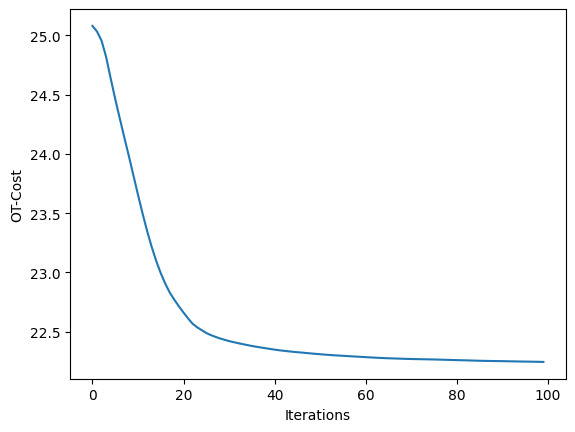

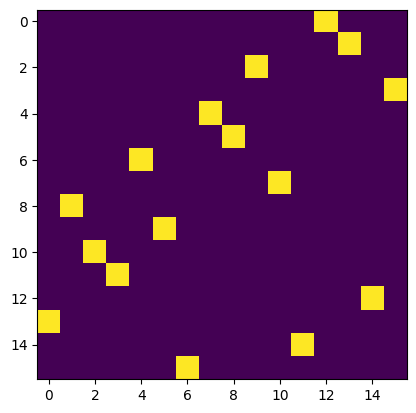

FRLC cost: 25.19497299194336
Created 2500 matching pairs


In [28]:
# Squared Euclidean cost p=2 or Euclidean if p=1
p = 1
K = 2

# Initialize dictionaries to store costs and sample sizes
costs = {
    'FRLC': {'samples': [], 'costs': []},
    'Sinkhorn': {'samples': [], 'costs': []},
    'ProgOT': {'samples': [], 'costs': []}
}

# Define pairwise Dist Mat
_X = torch.tensor(np.array(X)).float().to(device)
_Y = torch.tensor(np.array(Y)).float().to(device)

# Compute distance matrix
C = torch.cdist(_X, _Y)
print(f"Distance matrix shape: {C.shape}")

# Determine rank for FRLC
r = 16  # You can adjust this based on your dataset size
print(f"Using rank {r} for FRLC")

# Define the compute_OT_cost function
try:
    # Apply FRLC_opt for optimal transport
    Q, R, T, errs = FRLC_opt(
        C=C,
        gamma=30,
        r=r,
        max_iter=100,
        device=device,
        dtype=torch.float32,
        printCost=True,
        tau_in=100000
    )
    
    # Compute the full coupling matrix (this can be memory intensive)
    # P = Q @ torch.diag(1/torch.sum(Q, dim=0)) @ T @ torch.diag(1/torch.sum(R, dim=0)) @ R.T
    
    # Compute the OT cost using the new compute_OT_cost function
    Monge_clusters = [(i, j) for i in range(X.shape[0]) for j in range(Y.shape[0])]  # Example of clusters
    cost_frlc = FRLC_compute_OT_cost(_X, _Y, C=C, Monge_clusters=Monge_clusters, sq_Euclidean=(p == 2))
    
    costs['FRLC']['costs'].append(cost_frlc)
    costs['FRLC']['samples'].append(X.shape[0])
    
    print(f'FRLC cost: {cost_frlc}')
        
    # If you want to extract matching pairs (like the HierarchicalRefinement does)
    # For each row in X, find the highest probability match in Y
    indices_X = torch.arange(X.shape[0])
    P_approx = Q @ T @ R.T  # This is an approximation, might not fit in memory for large datasets
    matches_Y = torch.argmax(P_approx, dim=1)
    
    # Create matching pairs similar to F in HierarchicalRefinement
    F = []
    for i in range(X.shape[0]):
        F.append((torch.tensor([i]), torch.tensor([matches_Y[i].item()])))
    
    print(f"Created {len(F)} matching pairs")

except Exception as e:
    print(f'FRLC failed for sample size {X.shape[0]}: {e}')
    raise e